In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
dataset='sst2'
model_name='meta-llama/Llama-2-7b-hf'

results_path = f'mvp/checkpoints/{dataset}/{model_name}/textfooler/'

attacks = ['textbugger', 'textfooler']
ks = [1, 3, 7, 15, 31, 63, 127, 255, 511]
results = []
for seed in [1]:
    for shot in [16, 32, 64, 128, 256, 512]:
        for k in [x for x in ks if x < shot]:
            for attack in attacks:
                try:
                    file = f'{results_path}knn_icl-seed-{seed}-shot-{shot}/example-k-{k}/logs_{attack}_test.txt'
                    """
                    locate and parse the following in the file 
                    +-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 534    |
| Number of failed attacks:     | 178    |
| Number of skipped attacks:    | 160    |
| Original accuracy:            | 81.65% |
| Accuracy under attack:        | 20.41% |
| Attack success rate:          | 75.0%  |
| Average perturbed word %:     | 8.36%  |
| Average num. words per input: | 17.4   |
| Avg num queries:              | 74.37  |
| Adv confidence:               | 1.0    |
| Average Original Perplexity:  | 61.62  |
| Average Attack Perplexity:    | 86.19  |
| Average Attack USE Score:     | 0.88   |
+-------------------------------+--------+
                    """ 
                    with open(file, 'r') as f:
                        lines = f.readlines()
                except:
                    print(f'file {file} not found')
                    continue

                result = {'seed': seed, 'shot': shot, 'k': k, 'attack': attack}
                for line in lines:
                    if 'Original accuracy:' in line:
                        result['Clean Acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                    elif 'Accuracy under attack:' in line:
                        result['Attack Acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                    elif 'Attack success rate:' in line:
                        result['ASR'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                    elif 'Average perturbed word %:' in line:
                        result['Perturbed Word Ratio'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                    elif 'Average Attack Perplexity:' in line:
                        result['Attack Perplexity'] = float(line.split(':')[1].strip().strip('| '))

                results.append(result)


In [26]:
df = pd.DataFrame(results)
df.head()

,seed,shot,k,attack,Clean Acc,Attack Acc,ASR,Perturbed Word Ratio,Attack Perplexity
0,1,16,1,textbugger,77.75,39.11,49.71,8.19,90.80
1,1,16,1,textfooler,77.75,26.61,65.78,8.79,88.62
2,1,16,3,textbugger,84.40,17.55,79.21,18.22,121.35
3,1,16,3,textfooler,84.40,6.77,91.98,15.35,113.72
4,1,16,7,textbugger,87.16,15.37,82.37,19.81,129.62


/tmp/ipykernel_132078/2571388553.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=textfooler, x='k', y='Perturbed Word Ratio', hue='shot', palette=color_palette, ci=None, linewidth=2)


,shot,k,Perturbed Word Ratio
0,16,1,8.19
2,16,3,18.22
4,16,7,19.81
6,16,15,20.90
8,32,1,7.18


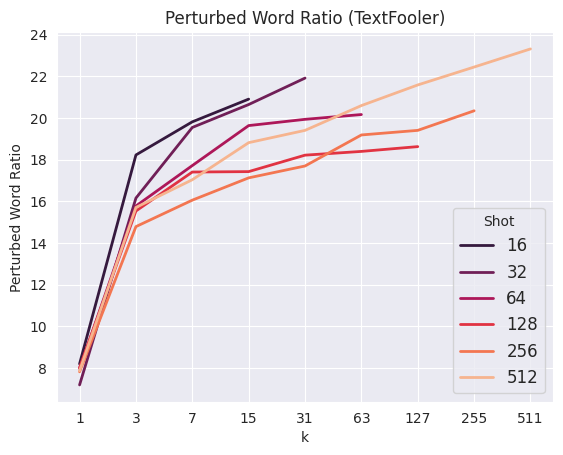

In [28]:
textfooler = df[df['attack'] == 'textbugger']

textfooler = textfooler[['shot', 'k', 'Perturbed Word Ratio']]
# keep unique row
textfooler = textfooler.drop_duplicates()

ks = [1, 3, 7, 15, 31, 63, 127, 255, 511]
# make k as string and categorical
textfooler['k'] = textfooler['k'].astype(str)
textfooler['k'] = textfooler['k'].astype('category')

color_palette = ['#311A3C', '#672555', '#9F2958', '#CF4448', '#E37D5A', '#ECB795']
color_palette = sns.color_palette("rocket")
# sort the k column
textfooler['k'] = textfooler['k'].cat.reorder_categories([str(k) for k in ks], ordered=True)
# plot line graph with k as the x-axis, Clean Acc as the y-axis and shot as the hue

# grid
sns.set_style("darkgrid")

sns.lineplot(data=textfooler, x='k', y='Perturbed Word Ratio', hue='shot', palette=color_palette, ci=None, linewidth=2)
# legend
plt.legend(loc='lower right', title='Shot', fontsize=12)
# title "Clean Acc vs k"
plt.title('Perturbed Word Ratio (TextFooler)')
# rescale x-axis as categorical

textfooler.head()